In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio.v2 as imageio
from scipy.optimize import curve_fit
from matplotlib.pyplot import subplots, subplots_adjust, savefig

from classy import Class
from astropy.cosmology import FlatLambdaCDM
from hmf.alternatives.wdm import MassFunctionWDM
from hmf import MassFunction
from halomod import HaloModel
from halomod import TracerHaloModel as HM

In [25]:
# Planck2018 parameters
params_2018 = {
    'tau_reio': 0.0544,
    'omega_cdm': 0.12,
    'omega_b': 0.02237,
    'n_s': 0.9649,
    'H0': 67.36,
    "output": 'tCl,pCl,lCl,mPk,mTk',
    "lensing": 'no', 
    "P_k_max_1/Mpc": 3.0,
    "T_cmb": 2.72548, 
    "z_pk": 0.0, 
    "sigma8": 0.8111
}

In [3]:
# Convert your params to a suitable format for FlatLambdaCDM
cosmo_2018 = FlatLambdaCDM(H0=params_2018['H0'], 
                      Om0=params_2018['omega_cdm'] + params_2018['omega_b'], 
                      Ob0=params_2018['omega_b'], 
                      Tcmb0=params_2018['T_cmb'])

In [4]:
def generate_gif_sigma8(base_params, sigma8_values):
    images = []
    filenames = []

    for sigma8_val in sigma8_values:
        hm = HaloModel(
            cosmo_model=cosmo_2018,
            hmf_model="SMT"
        )
        hm.update(sigma_8=sigma8_val)

        # Create the figure
        plt.figure(figsize=(10, 7))
        plt.loglog(hm.m, hm.dndlnm)
        plt.xlabel('Halo Mass [M$_\odot$]')
        plt.ylabel('dn/dlnM [Mpc$^{-3}$ M$_\odot^{-1}$]')
        plt.xlim(1e6, 1e18)
        plt.ylim(1e-25, 1e5)
        plt.title(f'Halo Mass Function for sigma8={sigma8_val}')

        # Save the figure as a png file
        filename = f'sigma8_{sigma8_val}.png'
        plt.savefig(filename)
        plt.close()

        # Append the image to the images list
        images.append(imageio.imread(filename))
        filenames.append(filename)

    # Save the images as a gif
    gif_filename = 'sigma8_gif.gif'
    imageio.mimsave(gif_filename, images)

    # Remove the individual .png files
    for filename in filenames:
        os.remove(filename)

    # Display the gif
    display(Image(filename=gif_filename))

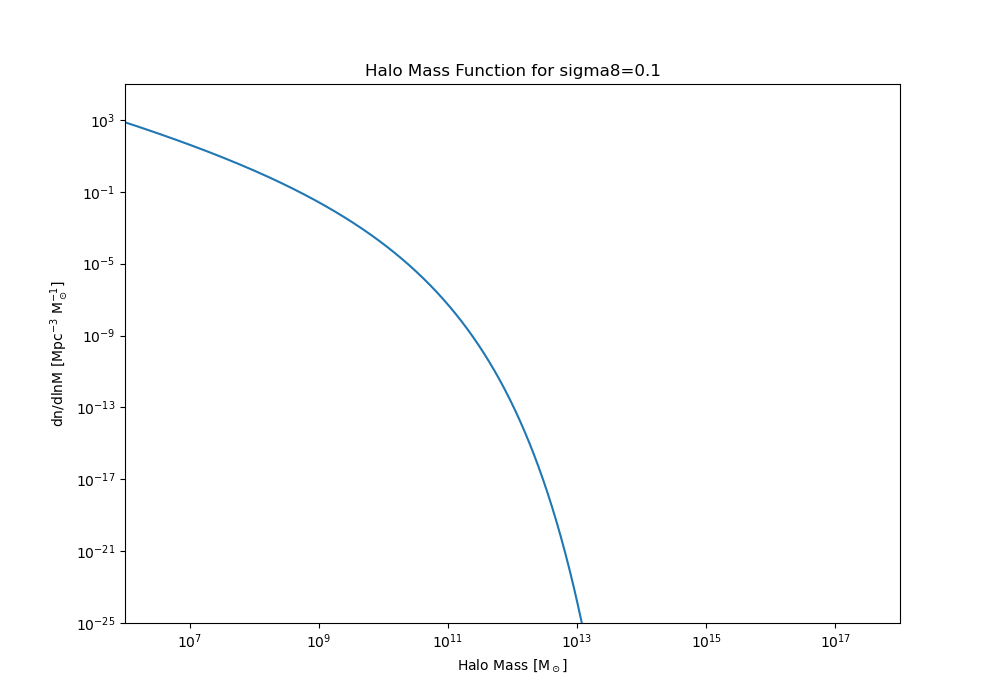

In [5]:
# Define your sigma8 values
sigma8_values = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 
                 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 
                 0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20]

# Generate GIF
generate_gif_sigma8(params_2018, sigma8_values)

In [10]:
def generate_gif_ns(base_params, ns_values):
    images = []
    filenames = []

    for ns_val in ns_values:
        # Update n_s in your base params
        params = base_params.copy()
        params['n_s'] = ns_val

        # Create a new cosmology with the updated n_s
        cosmo = FlatLambdaCDM(H0=params['H0'], 
                              Om0=params['omega_cdm'] + params['omega_b'], 
                              Ob0=params['omega_b'], 
                              Tcmb0=params['T_cmb'])

        hm = HaloModel(
            cosmo_model=cosmo,
            hmf_model="SMT",
            sigma_8 = params['sigma8'],
            n=ns_val  # Assuming the HaloModel takes n_s as "n"
        )

        # Create the figure
        plt.figure(figsize=(10, 7))
        plt.loglog(hm.m, hm.dndlnm)
        plt.xlabel('Halo Mass [M$_\odot$]')
        plt.ylabel('dn/dlnM [Mpc$^{-3}$ M$_\odot^{-1}$]')
        plt.xlim(1e6, 1e18)
        plt.ylim(1e-25, 1e5)
        plt.title(f'Halo Mass Function for n_s={ns_val}')

        # Save the figure as a png file
        filename = f'ns_{ns_val}.png'
        plt.savefig(filename)
        plt.close()

        # Append the image to the images list
        images.append(imageio.imread(filename))
        filenames.append(filename)

    # Save the images as a gif
    gif_filename = 'ns_gif.gif'
    imageio.mimsave(gif_filename, images)

    # Remove the individual .png files
    for filename in filenames:
        os.remove(filename)

    # Display the gif
    display(Image(filename=gif_filename))


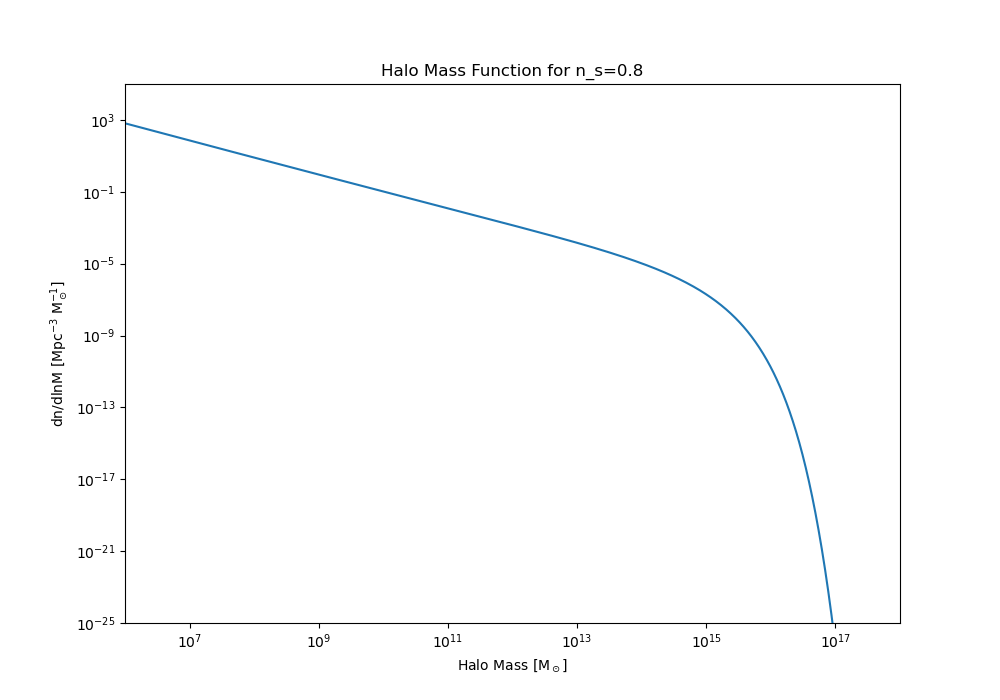

In [13]:
ns_values = [i/100 for i in range(80, 111)]
generate_gif_ns(params_2018, ns_values)

In [14]:
def setup_class(parameter):
    """
    It sets up the CLASS code with the given cosmological parameter.
    """
    c = Class()
    c.set(parameter)
    return c

In [46]:
def get_matter_spectrum(c, kmax, z_pk=0.0):
    """
    Returns the matter power spectrum for given cosmological parameters.
    """
    c.compute()
    kk = np.logspace(-5, np.log10(kmax), 2000)
    Pk = []
    h = c.h()
    for k in kk:
        Pk.append(c.pk(k*h, z_pk)*h**3)
    return kk, Pk

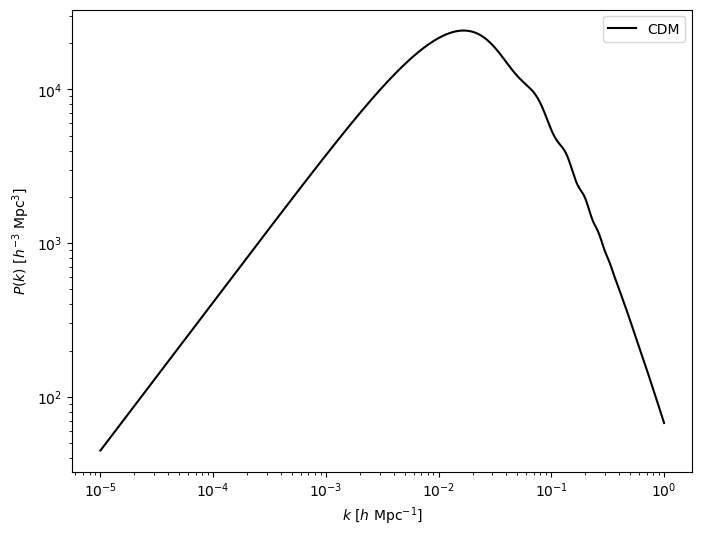

In [47]:
def setup_cdm_Pk(base_params, kmax, z_pk=0.0):
    """
    Returns the matter power spectrum for the base CDM model.
    """
    c = setup_class(base_params)
    kk, Pk_cdm = get_matter_spectrum(c, kmax, z_pk)
    return kk, Pk_cdm

# Get the Pk for the CDM model
kk, Pk_cdm = setup_cdm_Pk(params_2018, 1.0)

# Plot the Pk for the CDM model
plt.figure(figsize=(8,6))
plt.loglog(kk, Pk_cdm, 'k-', label='CDM')
plt.xlabel(r'$k\ [h\ \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)\ [h^{-3}\ \mathrm{Mpc}^3]$')
plt.legend()
plt.show()

In [48]:
def plot_transfer_function(base_params, param_name, param_values, ylim1, ylim2, kmax=1.0, z_pk=0.0 ):
    """
    Plots the transfer function for varying values of a parameter.
    """
    # Store images for the gif
    images = []

    # Loop over parameter values and plot
    for val in param_values:
        params = base_params.copy()
        params[param_name] = val
        c = setup_class(params)
        _, Pk = get_matter_spectrum(c, kmax, z_pk)
        
        T_k = np.sqrt(np.array(Pk) / np.array(Pk_cdm))

        plt.figure()
        plt.loglog(kk, T_k, label=f'{param_name} = {val}')
        plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
        plt.ylabel(r'$T(k)$')
        plt.ylim(ylim1, ylim2)
        plt.legend()
        plt.title(f"Transfer Function - {param_name} = {val}")
        img_name = f"tmp_{param_name}_{val}.png"
        plt.savefig(img_name)
        images.append(img_name)
        plt.close()

    # Convert list of images to gif
    with imageio.get_writer(f"{param_name}_evolution.gif", mode='I') as writer:
        for img_name in images:
            image = imageio.imread(img_name)
            writer.append_data(image)
            # Optionally delete the image after appending to gif if you don't want to keep them
            # os.remove(img_name)

    # Display gif
    display(Image(filename=f"{param_name}_evolution.gif"))


In [51]:
def plot_transfer_function_direct(base_params, param_name, param_values, ylim1, ylim2, kmax=1.0, z_pk=0.0 ):
    """
    Plots the transfer function for varying values of a parameter.
    """
    # Store images for the gif
    images = []

    # Loop over parameter values and plot
    for val in param_values:
        params = base_params.copy()
        params[param_name] = val
        c = setup_class(params)
        _, Pk = get_matter_spectrum(c, kmax, z_pk)
        
        T_k = np.sqrt(np.array(Pk))

        plt.figure()
        plt.loglog(kk, T_k, label=f'{param_name} = {val}')
        plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
        plt.ylabel(r'$T(k)$')
        plt.ylim(ylim1, ylim2)
        plt.legend()
        plt.title(f"Transfer Function - {param_name} = {val}")
        img_name = f"tmp_{param_name}_{val}.png"
        plt.savefig(img_name)
        images.append(img_name)
        plt.close()

    # Convert list of images to gif
    with imageio.get_writer(f"{param_name}_evolution.gif", mode='I') as writer:
        for img_name in images:
            image = imageio.imread(img_name)
            writer.append_data(image)
            # Optionally delete the image after appending to gif if you don't want to keep them
            # os.remove(img_name)

    # Display gif
    display(Image(filename=f"{param_name}_evolution.gif"))

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


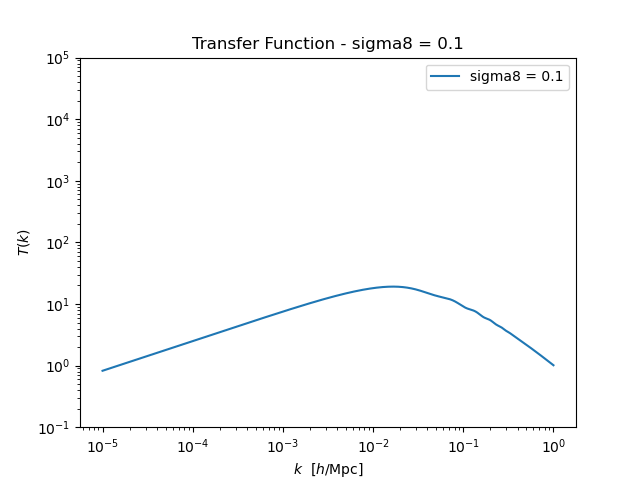

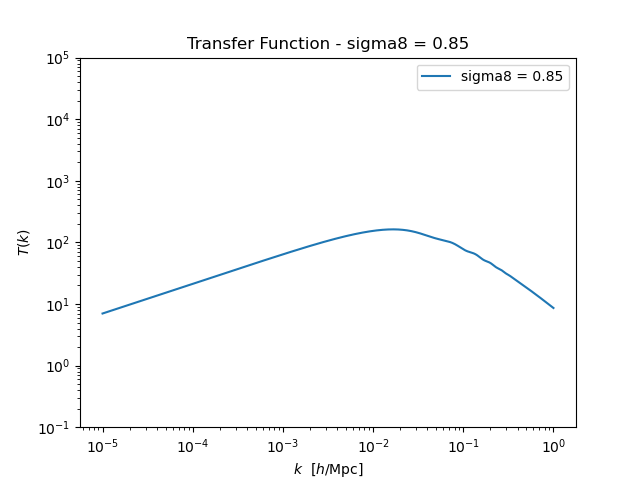

In [54]:
sigma8_values_small = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 
                 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]
sigma8_values_large = [0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20]

plot_transfer_function_direct(params_2018, 'sigma8', sigma8_values_small, 1e-1, 1e5)
plot_transfer_function_direct(params_2018, 'sigma8', sigma8_values_large, 1e-1, 1e5)

In [60]:
def generate_gif_omega_cdm(base_params, omega_cdm_values, h_values):
    images = []
    filenames = []

    if len(omega_cdm_values) != len(h_values):
        raise ValueError("The lists of omega_cdm_values and h_values must have the same length.")

    for omega_cdm_val, h_val in zip(omega_cdm_values, h_values):
        # Update omega_cdm and h in your base params
        params = base_params.copy()
        params['omega_cdm'] = omega_cdm_val
        params['H0'] = 100.0 * h_val  # Assuming H0 = 100 * h

        # Create a new cosmology with the updated omega_cdm
        cosmo = FlatLambdaCDM(H0=params['H0'], 
                              Om0=params['omega_cdm'] + params['omega_b'], 
                              Ob0=params['omega_b'], 
                              Tcmb0=params['T_cmb'])

        hm = HaloModel(
            cosmo_model=cosmo,
            hmf_model="SMT",
            sigma_8=params['sigma8'],
            n=params['n_s']  # Assuming the HaloModel takes n_s as "n"
        )

        # Create the figure
        plt.figure(figsize=(10, 7))
        plt.loglog(hm.m, hm.dndlnm)
        plt.xlabel('Halo Mass [M$_\odot$]')
        plt.ylabel('dn/dlnM [Mpc$^{-3}$ M$_\odot^{-1}$]')
        plt.xlim(1e6, 1e18)
        plt.ylim(1e-25, 1e5)
        plt.title(f'Halo Mass Function for omega_cdm={omega_cdm_val:.4f} and h={h_val:.2f}')

        # Save the figure as a png file
        filename = f'omega_cdm_{omega_cdm_val:.4f}_h_{h_val:.2f}.png'
        plt.savefig(filename)
        plt.close()

        # Append the image to the images list
        images.append(imageio.imread(filename))
        filenames.append(filename)

    # Save the images as a gif
    gif_filename = 'omega_cdm_h_evolution.gif'
    imageio.mimsave(gif_filename, images)

    # Remove the individual .png files
    for filename in filenames:
        os.remove(filename)

    # Display the gif
    display(Image(filename=gif_filename))


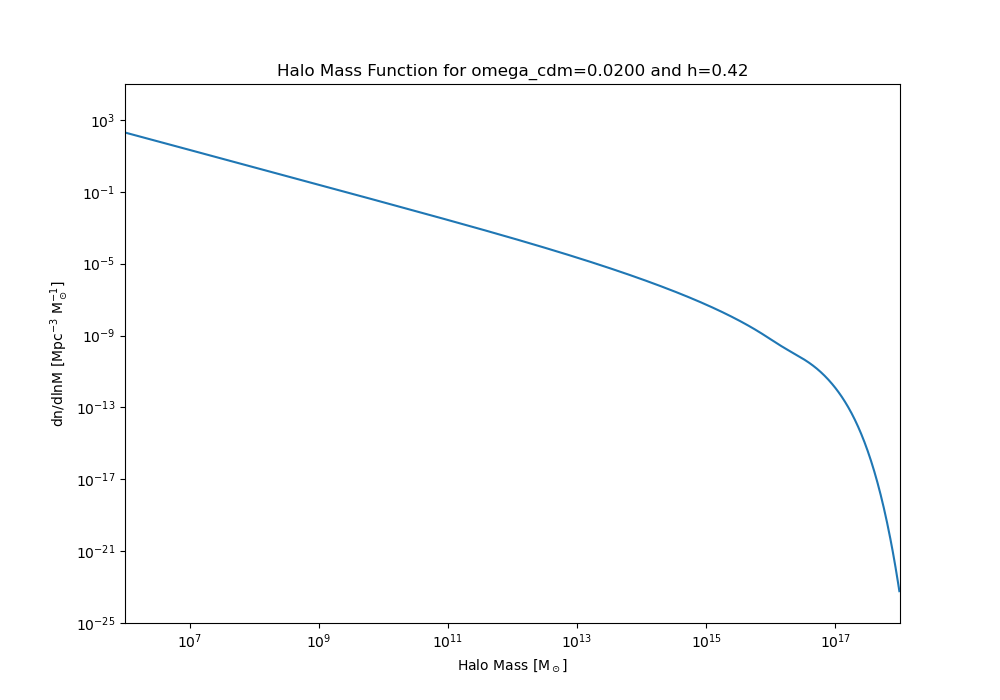

In [62]:
omega_cdm_values = [0.02, 0.03, 0.05, 0.08, 0.13, 0.20, 0.30, 0.50, 0.80,]
h_values = [0.42, 0.47, 0.55, 0.65, 0.80, 0.96, 1.20, 1.50, 1.90]
generate_gif_omega_cdm(params_2018, omega_cdm_values, h_values)

In [64]:
def generate_gif_omega_b(base_params, omega_b_values):
    images = []
    filenames = []

    # Define the constant sum of omega_b and omega_cdm
    constant_omega_sum = base_params['omega_cdm'] + base_params['omega_b']

    for omega_b_val in omega_b_values:
        # Update omega_b and omega_cdm in your base params
        params = base_params.copy()
        params['omega_b'] = omega_b_val
        params['omega_cdm'] = constant_omega_sum - omega_b_val

        # Create a new cosmology with the updated omega_b and adjusted omega_cdm
        cosmo = FlatLambdaCDM(H0=params['H0'], 
                              Om0=params['omega_cdm'] + params['omega_b'], 
                              Ob0=params['omega_b'], 
                              Tcmb0=params['T_cmb'])

        hm = HaloModel(
            cosmo_model=cosmo,
            hmf_model="SMT",
            sigma_8=params['sigma8'],
            n=params['n_s']  # Assuming the HaloModel takes n_s as "n"
        )

        # Create the figure
        plt.figure(figsize=(10, 7))
        plt.loglog(hm.m, hm.dndlnm)
        plt.xlabel('Halo Mass [M$_\odot$]')
        plt.ylabel('dn/dlnM [Mpc$^{-3}$ M$_\odot^{-1}$]')
        plt.xlim(1e6, 1e18)
        plt.ylim(1e-25, 1e5)
        plt.title(f'Halo Mass Function for omega_b={omega_b_val:.4f}')

        # Save the figure as a png file
        filename = f'omega_b_{omega_b_val:.4f}.png'
        plt.savefig(filename)
        plt.close()

        # Append the image to the images list
        images.append(imageio.imread(filename))
        filenames.append(filename)

    # Save the images as a gif
    gif_filename = 'omega_b_gif.gif'
    imageio.mimsave(gif_filename, images)

    # Remove the individual .png files
    for filename in filenames:
        os.remove(filename)

    # Display the gif
    display(Image(filename=gif_filename))


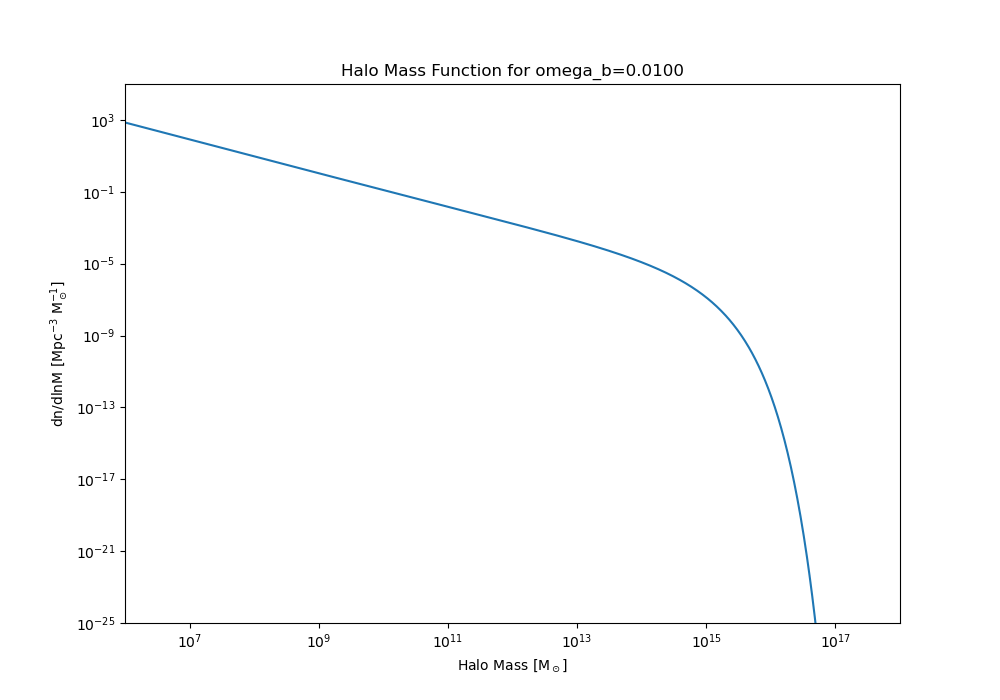

In [65]:
omega_b_values = [0.010, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.020, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.030]
generate_gif_omega_b(params_2018, omega_b_values)